
# Diffusion Monte Carlo

### n dimensions



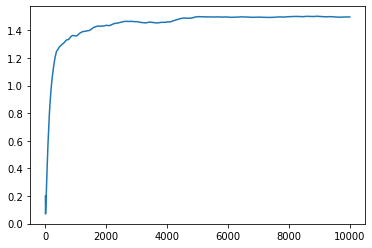

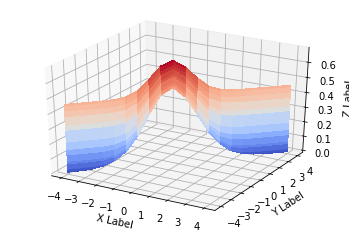

In [66]:
#INPUT

import numpy as np
import matplotlib.pyplot as plt
import math

#constants
d=3 #dimensions
n0=300;
nMax=700;
t0=100;
deltaT=0.01; #large to diffuse faster small to 
xMin=-4.0;
xMax=4.0
nBins=20; #number of spatial boxes
# hBar = 1.054571726*pow(10,-47) #hbar=1
e_R = 0.2


# calculate energy

psips=initialise_replicas(d,n0,nMax) #two dimensional matrix psips
energy(psips,d, t0,deltaT,e_R,n0, nMax)

# calculate Ground State 

psips=initialise_replicas(d,n0,nMax) #two dimensional matrix psips
groundState(psips,d,t0,deltaT,e_R,n0,nMax,xMin,xMax,nBins)


In [59]:
#INITIALISE REPLICAS


def initialise_replicas(d, n0,nMax):
    psips=[[0 for i in range(0,d+1)] for i in range (0,nMax)]
    for i in range (0,n0):
        psips[i][0]=1;


    return psips;



In [60]:
#WALK
import math
from random import gauss

def walk(psips,dim, deltaT):
    for i in range (0,len(psips)):
        if psips[i][0]==1:
            for j in range (1,d+1):
                psips[i][j]=psips[i][j]+math.sqrt(deltaT)*gauss(0.0,1.0);

    return psips;



In [61]:
#BRANCH
import math
import random


def branch(psips, d, e_R,deltaT,n0, nMax):
    
    hbar = 1.054571726*pow(10,-34)
#     calculate the initial number of replicas
    nInitial=0
    for i in range(0,len(psips)):
        if psips[i][0]==1:
            nInitial+=1
            
#     determine a stopping point
    last=0
    for i in reversed(range(0,len(psips))):
        if psips[i][0]==1:
            last=i
            break
    
#     birth-death process

#     m_0=0; m_1=0; m_2=0; m_3=0 #number of particles that have m=0/1/2/3
    vSum=0
    nFinal=0
    for i in range(0,last+1):
        v=0
        if(psips[i][0]==1):
            for j in range(1,d+1):
                v+=0.5*pow(psips[i][j],2)  # mass comes in here when we calculate for a molecule
            w= math.exp(-(v-e_R)*deltaT) #divide by hbar to be correct
            u= random.uniform(0,1)
            m= min(math.modf(w+u)[1],3) # each particle is replaced by m ones
            if m==0:
#                 m_0+=1
                psips[i][0]=0; #dead
            if m==1:
#                 m_1+=1
                vSum+=v
                nFinal+=1
            if m==2:
#                 m_2+=1
                vSum+=2*v
                nFinal+=2
                for k in range(0,len(psips)):
                    if(psips[k][0]==0):
                        psips[k][0]=1
                        for j in range(1,d+1):
                            psips[k][j]=psips[i][j]
                        break
            if m==3:
#                 m_3+=1
                vSum+=3*v
                nFinal+=3
                for k in range(0,len(psips)):
                    if(psips[k][0]==0):
                        psips[k][0]=1
                        for j in range(1,d+1):
                            psips[k][j]=psips[i][j]
                        break
                for k in range(0,len(psips)):
                    if(psips[k][0]==0):
                        psips[k][0]=1
                        for j in range(1,d+1):
                            psips[k][j]=psips[i][j]
                        break

#     print(m_0,end=" ");    print(m_1,end=" ");    print(m_2,end=" ");    print(m_3,end=" ");

#     calculate energies and average potential
    if nFinal!=0:
        vAverage=vSum/nFinal
        e_R=vAverage + hbar*(1-nFinal/nInitial)/deltaT #nFinal should be close to nInitial otherwise e_R is too large

    return psips, e_R, nInitial, nFinal;



In [62]:
#COUNT

import numpy as np

def count(psips,d,xMin,xMax, nBins):
    #     determine a stopping point
    last=0
    for i in reversed(range(0,len(psips))):
        if psips[i][0]==1:
            last=i
            break
            
    bins=np.linspace(xMin,xMax,nBins)
    replicaCount=[[0 for i in range(0,nBins)] for i in range (0,d)] # d rows of bins
    for i in range(0,last):
        if psips[i][0]==1: 
            for j in range(0,len(bins)-1): #next line calls bins[j+1]
                for k in range (0,d):
                    if psips[i][k+1]>=bins[j] and psips[i][k+1]<=bins[j+1]: #psips has an extra column
                        replicaCount[k][j]+=1
                        break
    return bins,replicaCount;

# psips=initialise_replicas(n0,nMax) #two dimensional matrix psips
# for i in range(0,10000):
#         psips=walk(psips,deltaT)
#         psips, e_R, n1, n2 = branch(psips,e_R,deltaT,n0, nMax)
# # print(psips)
# count(psips,-20,20,200)



In [63]:
#ENERGY

def energy(psips,d,t0,deltaT,e_R,n0,nMax):
    
    steps=math.floor(t0/deltaT)

    er1=[0]*(steps+1) #contains all the energies
    er1[0]=e_R
    totalE=e_R
    er2=[0]*(steps+1) #contains all the reference energies
    er2[0]=e_R
    
    for i in range (0,steps):
        psips=walk(psips,d,deltaT)
        psips, e_R, n1, n2 = branch(psips,d,e_R,deltaT,n0, nMax)
        er1[i+1]=e_R
        totalE+=e_R
        er2[i+1]=totalE/(i+2)
    #     print(er1[i+1], end=" ");    print(er2[i+1], end=" "); print (n1)
        if n1==0:
            break
        if n2==0:
            break

    plt.plot(er2)
    plt.show()



In [64]:
#GROUND STATE

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def groundState(psips,d,t0,deltaT,e_R,n0,nMax,xMin,xMax,nBins):
    

    distrib=[[0 for i in range(0,nBins)] for i in range (0,d)]
    steps=math.floor(t0/deltaT)
    for i in range(0,steps):
        psips=walk(psips,d,deltaT)
        psips, e_R, n1, n2 = branch(psips,d,e_R,deltaT,n0, nMax)
    
#     bins, replicaCount = count(psips,-20,20,200)
#     plt.plot(replicaCount)
#     for j in range(0,nBins):
#         distrib[j]+=replicaCount[j]
    
    for i in range(0,steps):
        psips=walk(psips,d,deltaT)
        psips, e_R, n1, n2 = branch(psips,d,e_R,deltaT,n0, nMax)
        bins, replicaCount = count(psips,d,xMin,xMax,nBins)
        for j in range(0,nBins):
            for k in range(0,d):
                distrib[k][j]+=replicaCount[k][j]
    

    sumSquares=[0 for i in range(0,d)]
    for i in range(0,nBins):
        for j in range(0,d):
            sumSquares[j]+=math.pow(distrib[j][i],2)
        
    for i in range(0,nBins):
        for j in range (0,d):
            distrib[j][i]=distrib[j][i]/math.sqrt(sumSquares[j])
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x,y=np.meshgrid(distrib[0],distrib[1])
    zs = np.sqrt(x**2 + y**2)
    xs=np.linspace(xMin,xMax,nBins)
    ys=np.linspace(xMin,xMax,nBins)
    ax.plot_surface(xs,ys , zs,cmap=cm.coolwarm,linewidth=0, antialiased=False)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()
    
#     y=max(distrib)*np.exp(-x*x/2)
#     plt.plot(x,y)
#     plt.show


        
        